In [140]:
import os
path_folder=r"C:\Users\Borsti\Desktop\Thesis\Code\GitHub Repo\rbergomi"
os.chdir(path_folder)

from datetime import datetime, timedelta
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
import pandas as pd
import pickle
import pytz
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
#% matplotlib inline

from yahoo_fin.options import get_options_chain, get_expiration_dates
from yahoo_fin.stock_info import get_live_price


## Read Data to be used for calculation!

In [141]:
def calculating_expiration(file_name, expiration_dates, loaded_dictionary):
    """Calculating all expirations of option chain in years and 
    combining all information into one DataFrame!"""
    
    # Time of File
    date_str = file_name[17:-4]
    str_format1 = "%Y-%m-%d"
    t_datetime = datetime.strptime(date_str, str_format1)


    df_all_maturities = pd.DataFrame()
    for i, val in enumerate(expiration_dates):

        # Time To Expiration
        str_format2 = "%B %d, %Y"
        exp_datetime = datetime.strptime(val, str_format2)

        # Calculating Time to Expiration in Years
        totsec = (exp_datetime - t_datetime).total_seconds()
        years = totsec / 3600 / 24 / 365
        tau = np.round(years, 3)
        
        # Storing all info in the dataframe
        df_maturity_t = loaded_dictionary[val]["calls"]
        df_maturity_t["Maturity"] = val
        df_maturity_t["Tau"] = tau
        df_all_maturities = pd.concat([df_all_maturities, df_maturity_t])
    return df_all_maturities

def clean_contracts(df):
    df2 = df.copy()
    
    str_format2 = "%B %d, %Y"
    exp_datetime_list = [datetime.strptime(x, str_format2) for x in df2["Maturity"].values]
    
    # calculate needed data
    mid = (df2["Ask"] + df2["Bid"])/2
    spread = df2["Ask"] - df2["Bid"]
    liquidity = spread/mid
    df2["Mid"] = mid
    df2["Spread"] = spread
    df2["Liquidity"] = liquidity
    df2["Keep"] = True

    # Translate reported date into python timestamp
    dt_str_list = [x.split(" ")[0] for x in df2["Last Trade Date"]]
    listasts = pd.DatetimeIndex(dt_str_list)
    df2["Last Trade Date"] = listasts
    df2 = df2.reset_index(drop=True)
    
    # Iterate through the df
    for index, row in df2.iterrows():

        # Identify too old trades/quotes
        date = row["Last Trade Date"]
        lasttrade_delta = (t_datetime - date).days
        if lasttrade_delta >= 1: # if last trade is older than 1 day

            delta_percent = lasttrade_delta/(exp_datetime_list[index] - date).days
            #print("need to check: ", lasttrade_delta)
            #print("delta: ", delta_percent)
            if delta_percent > 0.05:
                keep_var = False
            else:
                keep_var = True

        else:
            keep_var = True
            
        if keep_var == True:
            # Identify illiquid option contracts, for all that have been traded recently
            
            liquidity_i = row["Liquidity"]
            #print(liquidity_i)
            #print("liquidity: ", liquidity_i)
            if liquidity_i > 0.05 or liquidity_i < 0:
                keep_var = False
                #print("Keep?", keep_var)
            else:
                keep_var = True
                
            #print(liquidity_i, keep_var)
        df2.loc[index,"Keep"] = keep_var
        

    df_unclean = df2
    #display(df_clean_test)

    df_clean = df_unclean[df_unclean["Keep"]==True]
    #display(df_clean_test) 
    
    cleaned_num = len(df) - len(df_clean)
    print("Number of deleted contracts: ", cleaned_num)
    return df_clean, df_unclean

In [158]:
# Reading in Data
file_name =  "optionsData_AAPL_2021-06-25.pkl" #"optionsData_AAPL_2021-05-05.pkl"
# Time of File
date_str = file_name[17:-4]
str_format1 = "%Y-%m-%d"
t_datetime = datetime.strptime(date_str, str_format1)

ticker_str = file_name[12:16]
file_to_read = open(file_name, "rb")
loaded_dictionary = pickle.load(file_to_read)
expiration_dates = [key for key in loaded_dictionary]

# Combining all contracts for all maturities into one df
df_all_maturities = calculating_expiration(file_name, expiration_dates, loaded_dictionary)
# Cleaning the contracts
df_cleaned, df_uncleaned = clean_contracts(df_all_maturities)

Number of deleted contracts:  464


In [33]:
df_uncleaned.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,Mid,Spread,Liquidity,Keep
0,AAPL210702C00065000,2021-06-25,65.0,67.85,68.05,68.2,-1.2,-1.74%,8,6,181.25%,"July 2, 2021",0.019,68.125,0.15,0.002202,True
1,AAPL210702C00070000,2021-06-22,70.0,63.42,63.05,63.2,0,-,1,11,164.06%,"July 2, 2021",0.019,63.125,0.15,0.002376,False
2,AAPL210702C00075000,2021-06-25,75.0,58.00,58.05,58.2,3.9,+7.21%,2,10,146.88%,"July 2, 2021",0.019,58.125,0.15,0.002581,True
3,AAPL210702C00080000,2021-05-26,80.0,46.86,53.05,53.2,0,-,20,55,131.25%,"July 2, 2021",0.019,53.125,0.15,0.002824,False
4,AAPL210702C00085000,2021-06-02,85.0,48.45,48.05,48.2,0.15,+0.31%,1,58,117.19%,"July 2, 2021",0.019,48.125,0.15,0.003117,False


In [34]:
df_cleaned.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Maturity,Tau,Mid,Spread,Liquidity,Keep
0,AAPL210702C00065000,2021-06-25,65.0,67.85,68.05,68.2,-1.2,-1.74%,8,6,181.25%,"July 2, 2021",0.019,68.125,0.15,0.002202,True
2,AAPL210702C00075000,2021-06-25,75.0,58.00,58.05,58.2,3.9,+7.21%,2,10,146.88%,"July 2, 2021",0.019,58.125,0.15,0.002581,True
7,AAPL210702C00100000,2021-06-25,100.0,32.95,33.05,33.2,-0.7,-2.08%,32,133,77.34%,"July 2, 2021",0.019,33.125,0.15,0.004528,True
8,AAPL210702C00105000,2021-06-25,105.0,28.00,28.05,28.2,-1.12,-3.85%,1,121,65.63%,"July 2, 2021",0.019,28.125,0.15,0.005333,True
13,AAPL210702C00110000,2021-06-25,110.0,23.15,23.05,23.2,0.06,+0.26%,24,66,53.91%,"July 2, 2021",0.019,23.125,0.15,0.006486,True


In [143]:
df_cleaned=df_cleaned[df_cleaned["Tau"]==1.975]

In [159]:
df_cleaned=df_cleaned[df_cleaned["Tau"]==0.019]

In [161]:
#spot = 128.10 # 05.05.2021
spot =  133.11 # 25.6.2021 
mid = df_cleaned["Mid"].values
strikes = df_cleaned["Strike"].values
lm = np.log(spot/strikes)
ls = np.log(strikes/spot)

ttexp = df_cleaned["Tau"].values

In [135]:
a_2 = -0.43
eta_2 = 2.7
rho_2 = -0.75
xi_2 = 0.2

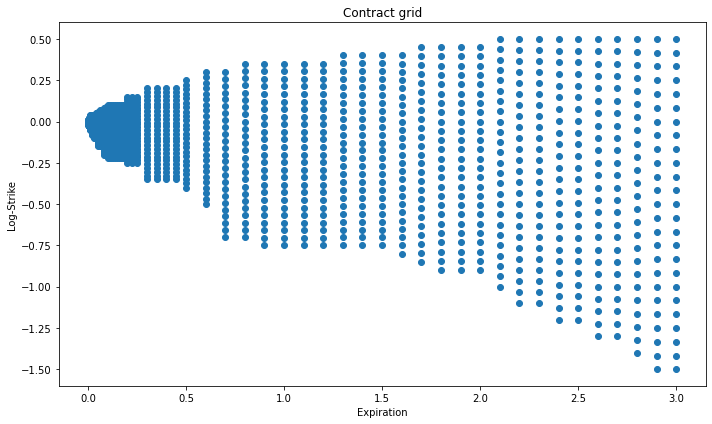

In [162]:
import NeuralNetworkPricing as nnp
weights_folder = path_folder + "\\roemer_weights_rbergomi"
contracts_folder = path_folder + "\\roemer_contracts"


# Define neural network based (rough Bergomi) model:
model = nnp.NeuralNetworkPricer(contracts_folder,weights_folder,"rbergomi")

# Plot the neural network contract grid:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
plt.scatter(model.T,model.k)
plt.title("Contract grid")
plt.xlabel("Expiration")
plt.ylabel("Log-Strike")
plt.tight_layout()
plt.show()

In [85]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(4)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T
import scipy

Original number of observations:  25
After filtering: 10


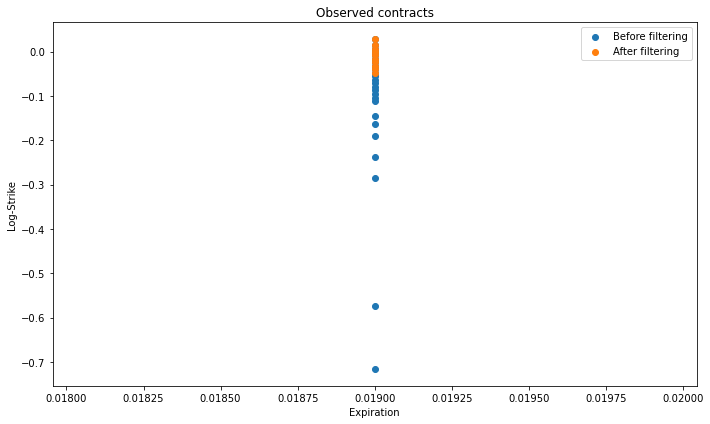

Optimisation message:  The maximum number of function evaluations is exceeded.
[True , Calibrated]: 


array([[ 0.1       ,  0.20120566],
       [ 1.9       ,  1.60686935],
       [-0.15      , -0.63697769],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,  0.03588384],
       [ 0.0025    ,

In [163]:
# Load example contracts:
k_orig = np.transpose([ls])# tmp[:,0].reshape(-1,1)
T_orig = np.transpose([ttexp])# tmp[:,1].reshape(-1,1)

# Filter contracts that are not within the neural network domain:
idxKeep = model.AreContractsInDomain(k_orig,T_orig)
k_obs = np.flip(k_orig[idxKeep,:])
T_obs = np.flip(T_orig[idxKeep,:])
mid_obs = np.flip(mid[idxKeep])

print("Original number of observations: ",len(k_orig))
print("After filtering:",len(k_obs))

# Plot contracts before and after filtering:
plt.figure(figsize=(10, 6))
plt.scatter(T_orig,k_orig,label="Before filtering")
plt.scatter(T_obs,k_obs,label="After filtering")
plt.title("Observed contracts")
plt.xlabel("Expiration")
plt.ylabel("Log-Strike")
plt.legend()
plt.tight_layout()
plt.show()



# Parameters as in Benessen
H_roemer = 0.1
eta_roemer = 1.9
rho_roemer = -0.15
xi_roemer = 0.05
parTrue = np.append(np.array([H_roemer,eta_roemer,rho_roemer]),(pow(xi_roemer,2))*np.ones((1,27))).reshape(30,1)

# Calculating Implied Volatilites via Black Scholes, as TRUE Implied Volatilities
#list of strikes after filtering
strikes_new = spot*np.exp(k_obs)
iv_obs = vec_bsinv(mid_obs,spot,np.squeeze(strikes_new),T_obs[0])
iv_obs = np.transpose([iv_obs])
#iv_obs = np.flip(iv_obs)

# Calibrate the model to see if we can recover the parameters:
# Remark: We simplify by forcing the forward variance curve flat. This also avoids an overparameterised model.
from scipy.optimize import minimize

# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
bounds = []
eps = pow(10,-6) 
for i in range(0,len(model.lb)):
    bounds.append([model.lb[i]+eps,model.ub[i]-eps])
    
# Fix the forward variance curve flat:
bounds = bounds[0:4]
idxConvPar = np.concatenate((np.array([0,1,2]),3*np.ones(27))).astype(int)
par0 = np.array([0.2,1.6,-0.7,pow(0.25,2)])

# Define the error function:
def err_fun(parEval):
    return(np.sum(pow(iv_obs - model.Eval(parEval[idxConvPar].reshape(-1,1),k_obs,T_obs),2)))

# Optimize:
bds = ([1.e-06, 0.750001, -0.999999, 0.002501], [0.499999, 3.499999, -1.e-06, 0.999999])
res=scipy.optimize.least_squares(err_fun,par0, bounds=bds, gtol=1E-10)
#res = minimize(err_fun,par0,method='L-BFGS-B',bounds=np.squeeze(bounds)) #minimize(err_fun,par0,method='L-BFGS-B',bounds=bounds)
print("Optimisation message: ", res.message)
parCalib = res.x[idxConvPar].reshape(-1,1)

# Compare calibrated and true parameters:
print("[True , Calibrated]: ")
np.concatenate((parTrue,parCalib),1)

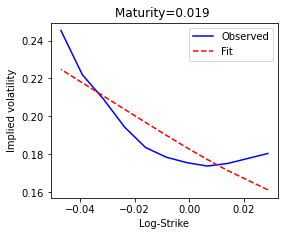

In [164]:
##### Plot the fit:
iv_fit = model.Eval(parCalib,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(14,12))
j = -1
iList = np.arange(0,len(uniqT))
for i in iList:
    j = j + 1
    plt.subplot(4,4,j+1)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[idxT],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-Strike")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.show()

In [123]:
partest = parCalib

In [ ]:
partest2 = parCalib